# SAT Scores for New York City Schools 

This project was created by the website dataquest.io. It consits of inspecting data for sat scores in New York City schools. For this project we will use data from a high school directory, NYC SAT test results, school math test results, class size, graduation results, and AP test results.  We will use this data to see if there are any correlations between SAT scores and the rest of the categories we have for New York City schools.

After cleaning the data from all 6 files in Excel, lets import the data files using pandas library

In [187]:
import pandas as pd
import numpy as np

In [188]:
files = ["APtestresults.csv", "classsize.csv", "schooldemographics.csv", "graduationresults.csv", "High_School_Directory.csv", "mathtestresults.csv", "2012_SAT_Results.csv"]

data = {}
for f in files:
    d = pandas.read_csv("{0}".format(f))
    data[f.replace(".csv", "")] = d

In [189]:
# Lets look at the class size table
data["classsize"].head(1)

,DBN,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,2M519,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN


DBN stands for district borough number. We want to condense the data so that there's only one DBN per high school. But the columns grade and program type have multiple values for each school. So we will only select values where the grade is "12-Sep" and program type is "gen ed".

In [190]:
class_size = data["classsize"]
class_size = class_size[class_size["GRADE "] == "12-Sep"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

In [191]:
class_size.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 7 columns):
DBN                                  690 non-null object
NUMBER OF STUDENTS / SEATS FILLED    690 non-null float64
NUMBER OF SECTIONS                   690 non-null float64
AVERAGE CLASS SIZE                   690 non-null float64
SIZE OF SMALLEST CLASS               690 non-null float64
SIZE OF LARGEST CLASS                690 non-null float64
SCHOOLWIDE PUPIL-TEACHER RATIO       0 non-null float64
dtypes: float64(6), object(1)
memory usage: 37.8+ KB


Now we will condense the math test results, graduation and demographics tables similarly

In [192]:
demographics = data["schooldemographics"]
demographics = demographics[demographics["schoolyear"] == 20112012]
data["schooldemographics"] = demographics

In [193]:
data["mathtestresults"] = data["mathtestresults"][data["mathtestresults"]["Year"] == 2011]
data["mathtestresults"] = data["mathtestresults"][data["mathtestresults"]["Grade"] == '8']

In [194]:
data["graduationresults"] = data["graduationresults"][data["graduationresults"]["Cohort"] == "2006"]
data["graduationresults"] = data["graduationresults"][data["graduationresults"]["Demographic"] == "Total Cohort"]


Now we convert all SAT scores from a string into a number, and we sum all SAT scores to get the total score

In [195]:
data['2012_SAT_Results'].head(1)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363


In [196]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["2012_SAT_Results"][c] = pd.to_numeric(data["2012_SAT_Results"][c])
    data['2012_SAT_Results']['Total Score'] = data['2012_SAT_Results'][cols[0]] + data['2012_SAT_Results'][cols[1]] + data['2012_SAT_Results'][cols[2]]


In [197]:
data['2012_SAT_Results'].head(1)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,Total Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363,1122


Now we print each file name and its first 5 rows

In [198]:
for i,d in data.items():
    print(i)
    print(d.head())

APtestresults
      DBN                      schoolName  AP Test Takers  Total Exams Taken  \
0  01M448    UNIVERsITY NEIGHBORHOOD H.s.              39                 49   
1  01M450          EAsT sIDE COMMUNITY Hs              19                 21   
2  01M515             LOWER EAsTsIDE PREP              24                 26   
3  01M539  NEW EXPLORATIONs sCI,TECH,MATH             255                377   
4  02M298                Pace High school              21                 21   

   Number of Exams with Scores 3 4 or 5  
0                                    10  
1                                     0  
2                                    24  
3                                   191  
4                                     0  
classsize
     DBN                SCHOOL NAME GRADE  PROGRAM TYPE  \
0  2M519  P.S. 015 Roberto Clemente     0K       GEN ED   
1  2M519  P.S. 015 Roberto Clemente     0K          CTT   
2  2M520  P.S. 015 Roberto Clemente      1       GEN ED   
3  2M52

Now we combine all data files into 1 using the DBN column as the joining point

In [199]:
flat_data_names = [k for k,v in data.items()]
flat_data = [data[k] for k in flat_data_names]
full = flat_data[0]
for i, f in enumerate(flat_data[1:]):
    name = flat_data_names[i+1]
    print(name)
    print(len(f["DBN"]) - len(f["DBN"].unique()))
    join_type = "inner"
    if name in ["sat_results", "ap_2010", "graduation"]:
        join_type = "outer"
    if name not in ["math_test_results"]:
        full = full.merge(f, on="DBN", how=join_type)

full.shape

classsize
26235
schooldemographics
0
graduationresults
0
High_School_Directory
0
mathtestresults
0
2012_SAT_Results
0
class_size
0


(483, 161)

Now we have our full DataFrame. We will convert the Advanced placement columns to numbers.

In [200]:
cols = ['AP Test Takers', 'Total Exams Taken', 'Number of Exams with Scores 3 4 or 5']

for col in cols:
    full[col] = pd.to_numeric(full[col])

In [201]:
# Filling out missing values with the average
full = full.fillna(full.mean())

Now we'll see if there are any correlations between SAT scores and the other columns

In [202]:
full.corr()['Total Score'].sort_values(ascending = False)

Total Score                             1.000000
SAT Writing Avg. Score                  0.993735
SAT Math Avg. Score                     0.987131
SAT Critical Reading Avg. Score         0.986520
asian_per                               0.926243
asian_num                               0.921831
white_per                               0.639538
Total Exams Taken                       0.634078
AP Test Takers                          0.617520
white_num                               0.598963
female_num                              0.554137
Total Cohort                            0.549738
Number of Exams with Scores 3 4 or 5    0.511480
NUMBER OF STUDENTS / SEATS FILLED_y     0.462751
Num of SAT Test Takers                  0.455634
NUMBER OF SECTIONS_y                    0.412706
total_students                          0.410223
female_per                              0.408286
AVERAGE CLASS SIZE_y                    0.344492
total_enrollment                        0.342196
NUMBER OF STUDENTS /

We can see that the strongest correlation to SAT scores is the percentage of Asian students in a class. While the percentage of males in a classroom and english language learners correlates negatively with SAT scores.

Now we'll make some plots so we can analzye our data easier

First we'll do a scatter plot of SAT Score vs Total Enrollment

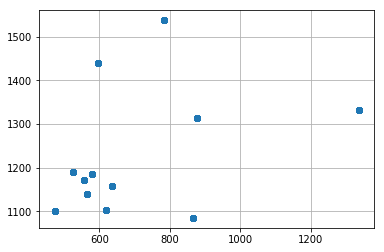

In [203]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(x='total_enrollment', y='Total Score', data=full)


You can see that lower scores correspond to schools with a lower number of students. We can print the names of these schools in the following way:

In [205]:
full[(full["total_enrollment"] < 650) & (full["Total Score"] < 1200)]["School Name"].value_counts()


WEST BRONX ACADEMY FOR THE FUTURE        51
THEATRE ARTS PRODUCTION COMPANY SCHOO    43
EAST BRONX ACADEMY FOR THE FUTURE        41
ACADEMY FOR COLLEGE PREPARATION AND C    35
PATHWAYS COLLEGE PREPARATORY SCHOOL:     34
BROOKLYN COLLEGIATE: A COLLEGE BOARD     32
PREPARATORY ACADEMY FOR WRITERS: A CO    29
Name: School Name, dtype: int64

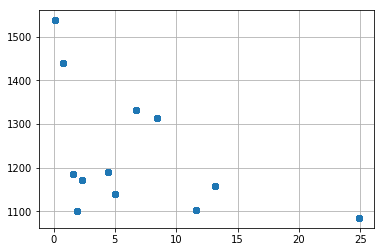

In [206]:
plt.scatter(x='ell_percent', y='Total Score',data=full)

The plot above is the percentage of english language learners in a school and their SAT score.  As you can see the lower the percentage of E.L.L., the higher the score.

Now we make a plot of how the percentage of ethnic students in a classroom correlates to SAT scores

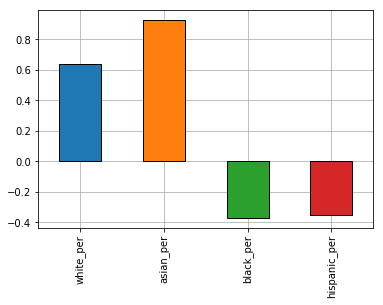

In [208]:
full.corr()["Total Score"][["white_per", "asian_per", "black_per", "hispanic_per"]].plot.bar()

Now a plot of gender percentages

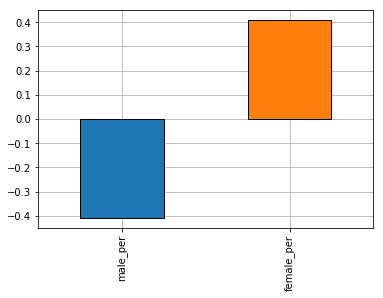

In [209]:
full.corr()["Total Score"][["male_per", "female_per"]].plot.bar()

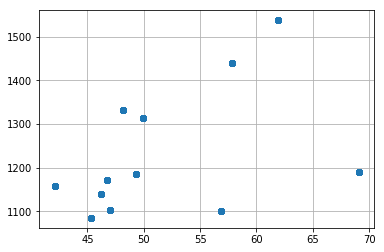

In [210]:
plt.scatter(x='female_per', y='Total Score',data=full)

In [211]:
# High schools with majority female and high SAT scores
full[(full["female_per"] > 55) & (full["Total Score"] > 1400)]["School Name"].value_counts()

WORLD JOURNALISM PREPARATORY: A COLLE    47
QUEENS GATEWAY TO HEALTH SCIENCES SEC    26
Name: School Name, dtype: int64

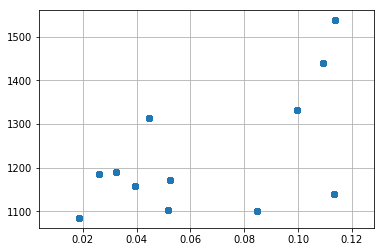

In [212]:
# Percentage of students who take advanced placement tests

full["ap_avg"] = full["AP Test Takers"] / full["total_enrollment"]

plt.scatter(x='ap_avg', y='Total Score',data=full)

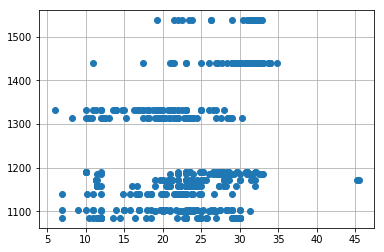

In [213]:
# And finally a plot of the average class size and SAT scores
plt.scatter(x='AVERAGE CLASS SIZE_x', y='Total Score',data=full)

It can be seen that classrooms with an average size between 18 and 34 get higher SAT scores